In [1]:
import pandas as pd 
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from itertools import product
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class VisualClassifier(nn.Module):
    def __init__(self):
        super(VisualClassifier, self).__init__()
        self.fc1 = nn.Linear(2048, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.7)
        self.fc2 = nn.Linear(256, 4)
        self.bn2 = nn.BatchNorm1d(4)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        return x

In [4]:
class TextClassifier(nn.Module):
    def __init__(self, input_dim=768, output_dim=4, hidden_dim=256):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [5]:
class AudialClassifier(nn.Module):
    def __init__(self):
        super(AudialClassifier, self).__init__()
        self.fc1 = nn.Linear(128, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(16, 4)
        self.bn2 = nn.BatchNorm1d(4)
   
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        return x

In [20]:
def train_model(model, dataloaders, optimizer, criterion, device, num_epochs=50, patience=10):

    """
    Trains and validates the model.
    
    Args:
    - model (torch.nn.Module): The PyTorch model to train.
    - dataloaders (dict): A dictionary containing 'train' and 'val' DataLoaders.
    - optimizer (torch.optim.Optimizer): The optimizer to use for training.
    - criterion (torch.nn.Module): The loss function.
    - num_epochs (int): The number of epochs to train for.
    - patience (int): The patience for early stopping.
    """
    best_val_f1 = -float('inf')  
    patience_counter = 0
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds = []
        val_labels = []
        val_probs = []
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(outputs.cpu().numpy())


        val_accuracy = np.mean(np.array(val_preds) == np.array(val_labels))
        val_f1 = f1_score(val_labels, val_preds, average='micro')
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1  
            patience_counter = 0  
            # print(f"Validation F1 improved. Saving model...")
            # torch.save(model.state_dict(), 'best_model_checkpoint.pth')
        else:
            patience_counter += 1 
            # print(f'Validation F1 did not improve. Patience: {patience_counter}/{patience}')
        
        # Early stopping check
        if patience_counter >= patience:
            print("Early stopping triggered")
            break  


    print(f'Validation Accuracy: {val_accuracy:.4f}, Best Validation F1 Score: {best_val_f1:.4f}')
    
    return val_accuracy, best_val_f1, np.array(val_probs), np.array(val_preds), np.array(val_labels)


In [7]:
def extract_and_pool_features(df, feature_types, base_path="../data/"):
    """
    Extracts features from specified columns in the DataFrame, applies mean pooling,
    and updates the DataFrame with new columns for these processed features.
    
    Args:
    - df (DataFrame): The pandas DataFrame containing the features.
    - feature_types (dict): A dictionary mapping from 'visual' and 'audio' to their respective column names in df.
    - base_path (str): Base path where the feature files are stored.
    """
    
    for key, column in feature_types.items():
        features_list = []
        for _, row in df.iterrows():
            file_path = row[column]
            features = np.load(f"{base_path}{file_path}")
            features_list.append(np.mean(features, axis=0) if key != 'text' else features)
        
        df[f'extracted_{key}_features'] = features_list


In [8]:
def prepare_datasets_and_loaders(df, feature_columns, label_column='emotion_labels', batch_size = 4, test_size = 0.2):
    """
    Prepares datasets and dataloaders for training and validation.
    
    Args:
    - df (DataFrame): The pandas DataFrame containing the pooled features and labels.
    - feature_columns (list): List of column names for the features to be used.
    - label_column (str): The column name where the label data is stored.
    - batch_size (int): Batch size for the dataloaders.
    - test_size (float): Proportion of the dataset to include in the test split.
    
    Returns:
    - A dictionary of dataloaders for training and validation for each feature type.
    """

    dataloaders = {}
    y = torch.tensor(df[label_column].values, dtype = torch.long)

    for feature_type in feature_columns:
        X = np.array(df[feature_type].tolist(), dtype = np.float32)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = test_size, random_state = 42)
        
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), y_train)
        val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val), y_val)
        
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
        val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
        
        dataloaders[f'{feature_type}_train'] = train_loader
        dataloaders[f'{feature_type}_val'] = val_loader

    return dataloaders



### Handle Class Imbalances

In [9]:
df = pd.read_csv('../data/csv/dataset.csv')

labels = df['emotion_labels'].values
classes = np.unique(labels)
class_weights = compute_class_weight('balanced', classes=classes, y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
class_weights_tensor = class_weights_tensor.to('cuda')


### RUN CLASSIFIER

In [22]:
model_aud = AudialClassifier()
model_aud = model_aud.to(device)

model_vis = VisualClassifier()
model_vis = model_vis.to(device)


model_text = TextClassifier()
model_text = model_text.to(device)

criterion = torch.nn.CrossEntropyLoss(weight = class_weights_tensor)

feature_types = {'visual': 'visual_features', 'audio': 'acoustic_features', 'text':'lexical_features'}
extract_and_pool_features(df, feature_types)

feature_columns = ['extracted_visual_features', 'extracted_audio_features','extracted_text_features']
dataloaders = prepare_datasets_and_loaders(df, feature_columns, batch_size = 16)

optimizer_aud = optim.Adam(model_aud.parameters(), lr = 0.001, weight_decay = 1e-4)
optimizer_vis = optim.Adam(model_vis.parameters(), lr = 0.001, weight_decay = 0)
optimizer_text = optim.Adam(model_vis.parameters(), lr = 0.001, weight_decay = 1e-4)


models_optimizers = {
    'extracted_visual_features': (model_vis, optimizer_vis),
    'extracted_audio_features': (model_aud, optimizer_aud),
    'extracted_text_features': (model_text, optimizer_text),
}

model_outputs = {}
for feature_type, (model, optimizer) in models_optimizers.items():
    print(f"Training with {feature_type}:")
    val_accuracy, best_val_f1, val_probs, val_preds, val_labels = train_model(
        model, 
        {'train': dataloaders[f'{feature_type}_train'], 'val': dataloaders[f'{feature_type}_val']}, 
        optimizer, criterion, device = device, num_epochs = 30, patience = 15)

    model_outputs[feature_type] = {
        'val_accuracy': val_accuracy,
        'best_val_f1': best_val_f1,
        'val_preds': val_preds,
        'val_labels': val_labels
    }


Training with extracted_visual_features:
Validation Accuracy: 0.5224, Best Validation F1 Score: 0.5336
Training with extracted_audio_features:
Early stopping triggered
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.5597
Training with extracted_text_features:
Validation Accuracy: 0.3582, Best Validation F1 Score: 0.3769


In [11]:
len(model_outputs['extracted_text_features']['val_labels'])

268

### PARAM GRID SEARCH

In [12]:
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'optimizer': [optim.Adam],
    'criterion': [nn.CrossEntropyLoss],
    'epochs': [30, 50],
    'batch_size': [4, 16, 32],
    'patience': [5, 10, 15],
    'weight_decay': [0, 1e-4, 1e-2],
}


def get_optimizer(optimizer_class, parameters, lr, weight_decay, momentum=None):
    if optimizer_class == optim.Adam:
        return optim.Adam(parameters, lr=lr, weight_decay=weight_decay)
    elif optimizer_class == optim.SGD:
        # Ensure momentum is provided for SGD; otherwise, default to 0
        return optim.SGD(parameters, lr=lr, momentum=momentum if momentum is not None else 0, weight_decay=weight_decay)


def get_criterion(criterion_class):
    if criterion_class == nn.CrossEntropyLoss:
        return nn.CrossEntropyLoss()
    elif criterion_class == nn.NLLLoss:
        return nn.NLLLoss()


In [13]:
def grid_search(df, feature_columns, param_grid, device='cuda'):
    max_vis_acc, max_aud_acc, max_text_acc = -np.inf, -np.inf, -np.inf
    best_params_vis, best_params_aud, best_params_text = None, None, None

    combinations = list(product(*param_grid.values()))

    for combination in tqdm(combinations):
        lr, optimizer_class, criterion_class, epochs, batch_size, patience, wd = combination
        
        dataloaders = prepare_datasets_and_loaders(df, feature_columns, batch_size=batch_size)
        
        model_vis = VisualClassifier().to(device)
        optimizer_vis = optim.Adam(model_vis.parameters(), lr=lr, weight_decay=wd)
        
        model_aud = AudialClassifier().to(device)
        optimizer_aud = optim.Adam(model_aud.parameters(), lr=lr, weight_decay=wd)

        model_text = TextClassifier().to(device)
        optimizer_text = optim.Adam(model_text.parameters(), lr=lr, weight_decay=wd)

        criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
        
        models_optimizers = {
            'extracted_visual_features': (model_vis, optimizer_vis),
            'extracted_audio_features': (model_aud, optimizer_aud),
            'extracted_text_features': (model_text, optimizer_text),
        }

        for feature_type, (model, optimizer) in models_optimizers.items():
            print(f"\nTraining {feature_type.split('_')[1].capitalize()} Model with lr={lr}, optimizer={optimizer_class.__name__}, criterion={criterion_class.__name__}, epochs={epochs}, batch_size={batch_size}, Patience={patience}, Weight decay={wd}")
            val_accuracy, best_val_f1, val_probs, val_preds, val_labels = train_model(
                model, 
                {'train': dataloaders[f'{feature_type}_train'], 'val': dataloaders[f'{feature_type}_val']}, 
                optimizer, criterion, device=device, num_epochs=epochs, patience=patience
            )

            if feature_type == 'extracted_visual_features' and val_accuracy > max_vis_acc:
                max_vis_acc = val_accuracy
                best_params_vis = {'learning_rate': lr, 'optimizer': optimizer_class.__name__, 'criterion': criterion_class.__name__, 'epochs': epochs, 'batch_size': batch_size, 'patience': patience, 'weight_decay': wd, 'validation_accuracy': val_accuracy}
            
            elif feature_type == 'extracted_audio_features' and val_accuracy > max_aud_acc:
                max_aud_acc = val_accuracy
                best_params_aud = {'learning_rate': lr, 'optimizer': optimizer_class.__name__, 'criterion': criterion_class.__name__, 'epochs': epochs, 'batch_size': batch_size, 'patience': patience, 'weight_decay': wd, 'validation_accuracy': val_accuracy}
            
            elif feature_type == 'extracted_text_features' and val_accuracy > max_text_acc:
                max_text_acc = val_accuracy
                best_params_text = {'learning_rate': lr, 'optimizer': optimizer_class.__name__, 'criterion': criterion_class.__name__, 'epochs': epochs, 'batch_size': batch_size, 'patience': patience, 'weight_decay': wd, 'validation_accuracy': val_accuracy}

    return best_params_vis, best_params_aud, best_params_text

In [35]:
vis_params, aud_params, text_params = grid_search(df, feature_columns, param_grid, device='cuda')
print("Best Visual Model Params:", vis_params)
print("Best Audio Model Params:", aud_params)
print("Best Text Model Params:", text_params)


  0%|          | 0/162 [00:00<?, ?it/s]


Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0
Validation Accuracy: 0.4664, Best Validation F1 Score: 0.4888

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0
Validation Accuracy: 0.5187, Best Validation F1 Score: 0.5410

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0


  1%|          | 1/162 [00:46<2:04:57, 46.57s/it]

Validation Accuracy: 0.6343, Best Validation F1 Score: 0.6754

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4030, Best Validation F1 Score: 0.4776

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5224, Best Validation F1 Score: 0.5261

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.0001


  1%|          | 2/162 [01:32<2:03:47, 46.42s/it]

Validation Accuracy: 0.6269, Best Validation F1 Score: 0.6306

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.01
Validation Accuracy: 0.4366, Best Validation F1 Score: 0.4552

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.01
Validation Accuracy: 0.4627, Best Validation F1 Score: 0.5037

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.01


  2%|▏         | 3/162 [02:21<2:06:11, 47.62s/it]

Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6716

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0
Validation Accuracy: 0.4664, Best Validation F1 Score: 0.5112

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5149

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0


  2%|▏         | 4/162 [03:08<2:04:47, 47.39s/it]

Validation Accuracy: 0.6045, Best Validation F1 Score: 0.6530

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.4851, Best Validation F1 Score: 0.4925

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5336

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.0001


  3%|▎         | 5/162 [03:57<2:05:16, 47.87s/it]

Validation Accuracy: 0.6157, Best Validation F1 Score: 0.6567

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.01
Validation Accuracy: 0.4515, Best Validation F1 Score: 0.4515

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5410, Best Validation F1 Score: 0.5410

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.01


  4%|▎         | 6/162 [04:57<2:15:12, 52.00s/it]

Validation Accuracy: 0.6194, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0
Validation Accuracy: 0.4664, Best Validation F1 Score: 0.4888

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5149

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0


  4%|▍         | 7/162 [05:45<2:10:40, 50.58s/it]

Validation Accuracy: 0.5858, Best Validation F1 Score: 0.6231

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.4515, Best Validation F1 Score: 0.4813

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.4739, Best Validation F1 Score: 0.5037

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.0001


  5%|▍         | 8/162 [06:31<2:05:58, 49.08s/it]

Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6231

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.01
Validation Accuracy: 0.4813, Best Validation F1 Score: 0.4851

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5261, Best Validation F1 Score: 0.5672

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.01


  6%|▌         | 9/162 [07:15<2:00:55, 47.42s/it]

Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6306

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5037

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0
Validation Accuracy: 0.4142, Best Validation F1 Score: 0.4291

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0


  6%|▌         | 10/162 [07:26<1:31:46, 36.23s/it]

Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4701, Best Validation F1 Score: 0.5037

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5299, Best Validation F1 Score: 0.5299

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.0001


  7%|▋         | 11/162 [07:37<1:12:01, 28.62s/it]

Validation Accuracy: 0.6194, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5112

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.01
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.5075

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.01


  7%|▋         | 12/162 [07:48<58:25, 23.37s/it]  

Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6343

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5336

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0
Validation Accuracy: 0.5261, Best Validation F1 Score: 0.5336

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0


  8%|▊         | 13/162 [08:00<48:49, 19.66s/it]

Validation Accuracy: 0.6045, Best Validation F1 Score: 0.6493

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5149

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5187, Best Validation F1 Score: 0.5261

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.0001


  9%|▊         | 14/162 [08:11<42:22, 17.18s/it]

Validation Accuracy: 0.6343, Best Validation F1 Score: 0.6343

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.01
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.5336

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5187, Best Validation F1 Score: 0.5299

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.01


  9%|▉         | 15/162 [08:22<37:47, 15.43s/it]

Validation Accuracy: 0.6455, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0
Validation Accuracy: 0.5000, Best Validation F1 Score: 0.5112

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0
Validation Accuracy: 0.4328, Best Validation F1 Score: 0.4701

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0


 10%|▉         | 16/162 [08:34<34:25, 14.15s/it]

Validation Accuracy: 0.6082, Best Validation F1 Score: 0.6343

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.4851, Best Validation F1 Score: 0.4925

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5000, Best Validation F1 Score: 0.5336

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.0001


 10%|█         | 17/162 [08:45<32:15, 13.35s/it]

Validation Accuracy: 0.6231, Best Validation F1 Score: 0.6343

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.01
Validation Accuracy: 0.4590, Best Validation F1 Score: 0.4963

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5075

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.01


 11%|█         | 18/162 [08:56<30:33, 12.73s/it]

Validation Accuracy: 0.6045, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5112

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0
Validation Accuracy: 0.4776, Best Validation F1 Score: 0.4776

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0


 12%|█▏        | 19/162 [09:02<25:37, 10.76s/it]

Validation Accuracy: 0.6418, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.4963

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4813, Best Validation F1 Score: 0.4925

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.0001


 12%|█▏        | 20/162 [09:09<22:22,  9.46s/it]

Validation Accuracy: 0.6194, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.01
Validation Accuracy: 0.4627, Best Validation F1 Score: 0.4851

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.01
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.4925

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.01


 13%|█▎        | 21/162 [09:15<19:58,  8.50s/it]

Validation Accuracy: 0.6418, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0
Validation Accuracy: 0.4440, Best Validation F1 Score: 0.4776

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0
Validation Accuracy: 0.5187, Best Validation F1 Score: 0.5187

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0


 14%|█▎        | 22/162 [09:21<18:14,  7.81s/it]

Validation Accuracy: 0.6231, Best Validation F1 Score: 0.6306

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.4739, Best Validation F1 Score: 0.4963

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.4739, Best Validation F1 Score: 0.4776

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.0001


 14%|█▍        | 23/162 [09:28<17:05,  7.38s/it]

Validation Accuracy: 0.6231, Best Validation F1 Score: 0.6493

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.01
Validation Accuracy: 0.4701, Best Validation F1 Score: 0.4739

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.01
Validation Accuracy: 0.4291, Best Validation F1 Score: 0.4590

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.01


 15%|█▍        | 24/162 [09:34<16:13,  7.06s/it]

Validation Accuracy: 0.6157, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5299

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0
Validation Accuracy: 0.4254, Best Validation F1 Score: 0.4366

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0


 15%|█▌        | 25/162 [09:40<15:31,  6.80s/it]

Validation Accuracy: 0.6306, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.4888, Best Validation F1 Score: 0.5149

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.4515, Best Validation F1 Score: 0.4813

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.0001


 16%|█▌        | 26/162 [09:47<15:05,  6.66s/it]

Validation Accuracy: 0.6418, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5149

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.01
Validation Accuracy: 0.4478, Best Validation F1 Score: 0.4552

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.01


 17%|█▋        | 27/162 [09:53<14:46,  6.57s/it]

Validation Accuracy: 0.6306, Best Validation F1 Score: 0.6306

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0
Validation Accuracy: 0.4888, Best Validation F1 Score: 0.5336

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0
Validation Accuracy: 0.5037, Best Validation F1 Score: 0.5261

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0


 17%|█▋        | 28/162 [11:01<56:11, 25.16s/it]

Validation Accuracy: 0.5746, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5037, Best Validation F1 Score: 0.5149

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5522, Best Validation F1 Score: 0.5560

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.0001


 18%|█▊        | 29/162 [12:11<1:25:18, 38.49s/it]

Validation Accuracy: 0.5970, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5000, Best Validation F1 Score: 0.5299

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5597, Best Validation F1 Score: 0.5597

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.01


 19%|█▊        | 30/162 [13:21<1:45:21, 47.89s/it]

Validation Accuracy: 0.6007, Best Validation F1 Score: 0.6567

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5037

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0
Validation Accuracy: 0.5410, Best Validation F1 Score: 0.5672

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0


 19%|█▉        | 31/162 [14:29<1:57:44, 53.93s/it]

Validation Accuracy: 0.6082, Best Validation F1 Score: 0.6306

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.4813, Best Validation F1 Score: 0.5224

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5560, Best Validation F1 Score: 0.5634

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.0001


 20%|█▉        | 32/162 [15:39<2:07:12, 58.71s/it]

Validation Accuracy: 0.6045, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5336

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5187, Best Validation F1 Score: 0.5373

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.01


 20%|██        | 33/162 [16:49<2:13:26, 62.07s/it]

Validation Accuracy: 0.6082, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5149

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5522

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0


 21%|██        | 34/162 [17:57<2:16:21, 63.92s/it]

Validation Accuracy: 0.5896, Best Validation F1 Score: 0.6530

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5373

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.4739, Best Validation F1 Score: 0.5299

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.0001


 22%|██▏       | 35/162 [19:07<2:19:00, 65.67s/it]

Validation Accuracy: 0.6418, Best Validation F1 Score: 0.6567

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5224, Best Validation F1 Score: 0.5261

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.01
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5112

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.01


 22%|██▏       | 36/162 [20:16<2:20:27, 66.88s/it]

Validation Accuracy: 0.5784, Best Validation F1 Score: 0.6343

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.5261

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0
Validation Accuracy: 0.5261, Best Validation F1 Score: 0.5410

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0


 23%|██▎       | 37/162 [20:35<1:48:56, 52.29s/it]

Validation Accuracy: 0.6157, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.5000

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4664, Best Validation F1 Score: 0.4664

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.0001


 23%|██▎       | 38/162 [20:53<1:27:16, 42.23s/it]

Validation Accuracy: 0.6343, Best Validation F1 Score: 0.6716

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5224

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5448, Best Validation F1 Score: 0.5821

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.01


 24%|██▍       | 39/162 [21:12<1:12:11, 35.21s/it]

Validation Accuracy: 0.6045, Best Validation F1 Score: 0.6231

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5075

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5149

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0


 25%|██▍       | 40/162 [21:31<1:01:16, 30.14s/it]

Validation Accuracy: 0.6045, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5000, Best Validation F1 Score: 0.5224

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5187, Best Validation F1 Score: 0.5448

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.0001


 25%|██▌       | 41/162 [21:49<53:55, 26.74s/it]  

Validation Accuracy: 0.6306, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5149

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.01
Validation Accuracy: 0.4478, Best Validation F1 Score: 0.5037

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.01


 26%|██▌       | 42/162 [22:08<48:50, 24.42s/it]

Validation Accuracy: 0.6194, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0
Validation Accuracy: 0.4664, Best Validation F1 Score: 0.5075

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0
Validation Accuracy: 0.4739, Best Validation F1 Score: 0.4888

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0


 27%|██▋       | 43/162 [22:27<44:47, 22.58s/it]

Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5037, Best Validation F1 Score: 0.5261

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5410, Best Validation F1 Score: 0.5522

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.0001


 27%|██▋       | 44/162 [22:45<42:13, 21.47s/it]

Validation Accuracy: 0.6194, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5336

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5410, Best Validation F1 Score: 0.5448

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.01


 28%|██▊       | 45/162 [23:04<40:24, 20.72s/it]

Validation Accuracy: 0.6082, Best Validation F1 Score: 0.6493

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0
Validation Accuracy: 0.4888, Best Validation F1 Score: 0.5075

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5149

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0


 28%|██▊       | 46/162 [23:15<33:56, 17.56s/it]

Validation Accuracy: 0.6493, Best Validation F1 Score: 0.6493

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5000, Best Validation F1 Score: 0.5149

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4739, Best Validation F1 Score: 0.4851

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.0001


 29%|██▉       | 47/162 [23:25<29:33, 15.42s/it]

Validation Accuracy: 0.6343, Best Validation F1 Score: 0.6642

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5075

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.01
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5075

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.01


 30%|██▉       | 48/162 [23:36<26:33, 13.97s/it]

Validation Accuracy: 0.6045, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0
Validation Accuracy: 0.5037, Best Validation F1 Score: 0.5299

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5000

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0


 30%|███       | 49/162 [23:47<24:33, 13.04s/it]

Validation Accuracy: 0.6269, Best Validation F1 Score: 0.6530

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.4739, Best Validation F1 Score: 0.5075

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5373

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.0001


 31%|███       | 50/162 [23:57<22:52, 12.26s/it]

Validation Accuracy: 0.6231, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5000, Best Validation F1 Score: 0.5037

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5336, Best Validation F1 Score: 0.5373

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.01


 31%|███▏      | 51/162 [24:07<21:41, 11.73s/it]

Validation Accuracy: 0.6082, Best Validation F1 Score: 0.6642

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0
Validation Accuracy: 0.4664, Best Validation F1 Score: 0.4851

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0
Validation Accuracy: 0.5037, Best Validation F1 Score: 0.5149

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0


 32%|███▏      | 52/162 [24:18<20:38, 11.26s/it]

Validation Accuracy: 0.6306, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5037, Best Validation F1 Score: 0.5037

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5224

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.0001


 33%|███▎      | 53/162 [24:28<20:00, 11.01s/it]

Validation Accuracy: 0.6269, Best Validation F1 Score: 0.6343

Training Visual Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.01
Validation Accuracy: 0.4664, Best Validation F1 Score: 0.4963

Training Audio Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5224, Best Validation F1 Score: 0.5448

Training Text Model with lr=0.0001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.01


 33%|███▎      | 54/162 [24:39<19:33, 10.86s/it]

Validation Accuracy: 0.6306, Best Validation F1 Score: 0.6530

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0
Validation Accuracy: 0.4888, Best Validation F1 Score: 0.4888

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0
Validation Accuracy: 0.5746, Best Validation F1 Score: 0.5746

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0


 34%|███▍      | 55/162 [25:20<35:27, 19.88s/it]

Validation Accuracy: 0.6157, Best Validation F1 Score: 0.6306

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4739, Best Validation F1 Score: 0.4925

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5522, Best Validation F1 Score: 0.5933

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.0001


 35%|███▍      | 56/162 [26:02<47:02, 26.63s/it]

Validation Accuracy: 0.6231, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.01
Validation Accuracy: 0.4067, Best Validation F1 Score: 0.4440

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5672, Best Validation F1 Score: 0.5970

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.01


 35%|███▌      | 57/162 [26:44<54:46, 31.30s/it]

Validation Accuracy: 0.5970, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0
Validation Accuracy: 0.4888, Best Validation F1 Score: 0.5261

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0
Validation Accuracy: 0.5672, Best Validation F1 Score: 0.6045

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0


 36%|███▌      | 58/162 [27:25<59:13, 34.17s/it]

Validation Accuracy: 0.6082, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5037

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5410, Best Validation F1 Score: 0.5933

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.0001


 36%|███▋      | 59/162 [28:07<1:02:47, 36.58s/it]

Validation Accuracy: 0.5933, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.01
Validation Accuracy: 0.3657, Best Validation F1 Score: 0.4552

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5634, Best Validation F1 Score: 0.5970

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.01


 37%|███▋      | 60/162 [28:49<1:04:58, 38.22s/it]

Validation Accuracy: 0.5970, Best Validation F1 Score: 0.6343

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0
Validation Accuracy: 0.4664, Best Validation F1 Score: 0.5075

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0
Validation Accuracy: 0.5784, Best Validation F1 Score: 0.5821

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0


 38%|███▊      | 61/162 [29:30<1:05:45, 39.07s/it]

Validation Accuracy: 0.5896, Best Validation F1 Score: 0.6493

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.4851, Best Validation F1 Score: 0.4851

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5224, Best Validation F1 Score: 0.5784

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.0001


 38%|███▊      | 62/162 [30:12<1:06:41, 40.02s/it]

Validation Accuracy: 0.5560, Best Validation F1 Score: 0.6231

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.01
Validation Accuracy: 0.4216, Best Validation F1 Score: 0.4403

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5485, Best Validation F1 Score: 0.5858

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.01


 39%|███▉      | 63/162 [30:55<1:07:03, 40.64s/it]

Validation Accuracy: 0.6157, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0
Validation Accuracy: 0.5299, Best Validation F1 Score: 0.5448

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0
Validation Accuracy: 0.5224, Best Validation F1 Score: 0.5373

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0


 40%|███▉      | 64/162 [31:06<51:53, 31.77s/it]  

Validation Accuracy: 0.5896, Best Validation F1 Score: 0.6343

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5299

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4664, Best Validation F1 Score: 0.5224

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.0001


 40%|████      | 65/162 [31:17<41:29, 25.67s/it]

Validation Accuracy: 0.6157, Best Validation F1 Score: 0.6343

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.01
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5075

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5187, Best Validation F1 Score: 0.5299

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.01


 41%|████      | 66/162 [31:28<34:11, 21.37s/it]

Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5485

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0
Validation Accuracy: 0.5187, Best Validation F1 Score: 0.5336

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0


 41%|████▏     | 67/162 [31:40<29:19, 18.52s/it]

Validation Accuracy: 0.6194, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.4851, Best Validation F1 Score: 0.5373

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5299

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.0001


 42%|████▏     | 68/162 [31:52<25:48, 16.48s/it]

Validation Accuracy: 0.6045, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5037, Best Validation F1 Score: 0.5037

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5299, Best Validation F1 Score: 0.5522

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.01


 43%|████▎     | 69/162 [32:03<23:13, 14.98s/it]

Validation Accuracy: 0.5821, Best Validation F1 Score: 0.6269

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5448

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0
Validation Accuracy: 0.4813, Best Validation F1 Score: 0.5261

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0


 43%|████▎     | 70/162 [32:15<21:13, 13.85s/it]

Validation Accuracy: 0.6082, Best Validation F1 Score: 0.6269

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5299

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5261, Best Validation F1 Score: 0.5597

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.0001


 44%|████▍     | 71/162 [32:26<19:53, 13.12s/it]

Validation Accuracy: 0.6306, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.01
Validation Accuracy: 0.4851, Best Validation F1 Score: 0.5261

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5187, Best Validation F1 Score: 0.5485

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.01


 44%|████▍     | 72/162 [32:38<19:01, 12.68s/it]

Validation Accuracy: 0.6007, Best Validation F1 Score: 0.6269

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5299

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0
Validation Accuracy: 0.5187, Best Validation F1 Score: 0.5560

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0


 45%|████▌     | 73/162 [32:44<15:58, 10.77s/it]

Validation Accuracy: 0.6269, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4851, Best Validation F1 Score: 0.5299

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4851, Best Validation F1 Score: 0.4888

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.0001


 46%|████▌     | 74/162 [32:51<13:53,  9.47s/it]

Validation Accuracy: 0.6231, Best Validation F1 Score: 0.6343

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5037, Best Validation F1 Score: 0.5149

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5187, Best Validation F1 Score: 0.5336

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.01


 46%|████▋     | 75/162 [32:58<12:57,  8.94s/it]

Validation Accuracy: 0.6343, Best Validation F1 Score: 0.6530

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5336

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.5448

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0


 47%|████▋     | 76/162 [33:05<11:53,  8.29s/it]

Validation Accuracy: 0.6157, Best Validation F1 Score: 0.6493

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5448

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5336, Best Validation F1 Score: 0.5672

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.0001


 48%|████▊     | 77/162 [33:12<11:23,  8.04s/it]

Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.01
Validation Accuracy: 0.4851, Best Validation F1 Score: 0.5373

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5299, Best Validation F1 Score: 0.5672

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.01


 48%|████▊     | 78/162 [33:20<11:07,  7.95s/it]

Validation Accuracy: 0.6231, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0
Validation Accuracy: 0.4851, Best Validation F1 Score: 0.5187

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0
Validation Accuracy: 0.5299, Best Validation F1 Score: 0.5597

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0


 49%|████▉     | 79/162 [33:27<10:29,  7.59s/it]

Validation Accuracy: 0.6007, Best Validation F1 Score: 0.6306

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5261

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.4888, Best Validation F1 Score: 0.5187

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.0001


 49%|████▉     | 80/162 [33:34<10:10,  7.44s/it]

Validation Accuracy: 0.6231, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5000, Best Validation F1 Score: 0.5336

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5485

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.01


 50%|█████     | 81/162 [33:41<09:51,  7.31s/it]

Validation Accuracy: 0.6343, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0
Validation Accuracy: 0.5000, Best Validation F1 Score: 0.5187

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0
Validation Accuracy: 0.5784, Best Validation F1 Score: 0.5933

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0


 51%|█████     | 82/162 [34:56<36:54, 27.68s/it]

Validation Accuracy: 0.5821, Best Validation F1 Score: 0.6343

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4851, Best Validation F1 Score: 0.5187

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5485, Best Validation F1 Score: 0.5896

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.0001


 51%|█████     | 83/162 [36:13<55:44, 42.34s/it]

Validation Accuracy: 0.6082, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.01
Validation Accuracy: 0.4291, Best Validation F1 Score: 0.4664

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5522, Best Validation F1 Score: 0.5896

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.01


 52%|█████▏    | 84/162 [37:29<1:08:14, 52.50s/it]

Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6716

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0
Validation Accuracy: 0.4739, Best Validation F1 Score: 0.5112

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0
Validation Accuracy: 0.5672, Best Validation F1 Score: 0.6007

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0


 52%|█████▏    | 85/162 [38:44<1:15:53, 59.13s/it]

Validation Accuracy: 0.5933, Best Validation F1 Score: 0.6306

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5112

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5784, Best Validation F1 Score: 0.5896

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.0001


 53%|█████▎    | 86/162 [40:00<1:21:27, 64.30s/it]

Validation Accuracy: 0.5821, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.01
Validation Accuracy: 0.3881, Best Validation F1 Score: 0.4552

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5187, Best Validation F1 Score: 0.5858

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.01


 54%|█████▎    | 87/162 [41:16<1:24:50, 67.87s/it]

Validation Accuracy: 0.5746, Best Validation F1 Score: 0.6306

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5112

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0
Validation Accuracy: 0.5709, Best Validation F1 Score: 0.5709

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0


 54%|█████▍    | 88/162 [42:31<1:26:11, 69.88s/it]

Validation Accuracy: 0.5821, Best Validation F1 Score: 0.6194

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.4851, Best Validation F1 Score: 0.5224

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5485, Best Validation F1 Score: 0.5970

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.0001


 55%|█████▍    | 89/162 [43:47<1:27:12, 71.68s/it]

Validation Accuracy: 0.5709, Best Validation F1 Score: 0.6343

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.01
Validation Accuracy: 0.4067, Best Validation F1 Score: 0.4925

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5560, Best Validation F1 Score: 0.6007

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.01


 56%|█████▌    | 90/162 [45:04<1:28:08, 73.46s/it]

Validation Accuracy: 0.5970, Best Validation F1 Score: 0.6343

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.5522

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5560

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0


 56%|█████▌    | 91/162 [45:24<1:08:01, 57.48s/it]

Validation Accuracy: 0.6493, Best Validation F1 Score: 0.6493

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5261, Best Validation F1 Score: 0.5373

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5000, Best Validation F1 Score: 0.5522

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.0001


 57%|█████▋    | 92/162 [45:45<54:10, 46.44s/it]  

Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6306

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.01
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.5187

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.01
Validation Accuracy: 0.4701, Best Validation F1 Score: 0.5261

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.01


 57%|█████▋    | 93/162 [46:05<44:24, 38.62s/it]

Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5373

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0
Validation Accuracy: 0.4664, Best Validation F1 Score: 0.5336

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0


 58%|█████▊    | 94/162 [46:25<37:26, 33.04s/it]

Validation Accuracy: 0.5896, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5373, Best Validation F1 Score: 0.5485

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5224

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.0001


 59%|█████▊    | 95/162 [46:46<32:38, 29.24s/it]

Validation Accuracy: 0.6157, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5373

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5597

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.01


 59%|█████▉    | 96/162 [47:07<29:21, 26.68s/it]

Validation Accuracy: 0.6306, Best Validation F1 Score: 0.6530

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0
Validation Accuracy: 0.4776, Best Validation F1 Score: 0.5373

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0
Validation Accuracy: 0.4888, Best Validation F1 Score: 0.5261

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0


 60%|█████▉    | 97/162 [47:28<27:08, 25.05s/it]

Validation Accuracy: 0.6269, Best Validation F1 Score: 0.6306

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5224, Best Validation F1 Score: 0.5448

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5261

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.0001


 60%|██████    | 98/162 [47:49<25:25, 23.84s/it]

Validation Accuracy: 0.6045, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5261

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5485

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.01


 61%|██████    | 99/162 [48:09<24:01, 22.87s/it]

Validation Accuracy: 0.5784, Best Validation F1 Score: 0.6604

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5373

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0
Validation Accuracy: 0.5448, Best Validation F1 Score: 0.5821

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0


 62%|██████▏   | 100/162 [48:21<20:00, 19.37s/it]

Validation Accuracy: 0.6082, Best Validation F1 Score: 0.6493

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5037, Best Validation F1 Score: 0.5336

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5224, Best Validation F1 Score: 0.5410

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.0001


 62%|██████▏   | 101/162 [48:32<17:16, 17.00s/it]

Validation Accuracy: 0.6157, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5373

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.01
Validation Accuracy: 0.4851, Best Validation F1 Score: 0.5448

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.01


 63%|██████▎   | 102/162 [48:43<15:18, 15.30s/it]

Validation Accuracy: 0.6007, Best Validation F1 Score: 0.6604

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0
Validation Accuracy: 0.5261, Best Validation F1 Score: 0.5373

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0
Validation Accuracy: 0.5261, Best Validation F1 Score: 0.5672

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0


 64%|██████▎   | 103/162 [48:55<13:50, 14.08s/it]

Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6493

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5336

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5634

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.0001


 64%|██████▍   | 104/162 [49:06<12:50, 13.28s/it]

Validation Accuracy: 0.6231, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.01
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.5336

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.01
Validation Accuracy: 0.4851, Best Validation F1 Score: 0.5634

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.01


 65%|██████▍   | 105/162 [49:19<12:25, 13.08s/it]

Validation Accuracy: 0.5970, Best Validation F1 Score: 0.6530

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5448

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0
Validation Accuracy: 0.4851, Best Validation F1 Score: 0.5448

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0


 65%|██████▌   | 106/162 [49:30<11:42, 12.54s/it]

Validation Accuracy: 0.6157, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5224, Best Validation F1 Score: 0.5410

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5373, Best Validation F1 Score: 0.5522

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.0001


 66%|██████▌   | 107/162 [49:42<11:13, 12.25s/it]

Validation Accuracy: 0.6157, Best Validation F1 Score: 0.6530

Training Visual Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5410

Training Audio Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5373

Training Text Model with lr=0.001, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.01


 67%|██████▋   | 108/162 [49:53<10:48, 12.01s/it]

Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0
Validation Accuracy: 0.4888, Best Validation F1 Score: 0.4925

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0
Validation Accuracy: 0.5299, Best Validation F1 Score: 0.5933

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0


 67%|██████▋   | 109/162 [50:38<19:26, 22.01s/it]

Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6604

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.3993, Best Validation F1 Score: 0.4552

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5784, Best Validation F1 Score: 0.5970

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.0001


 68%|██████▊   | 110/162 [51:25<25:30, 29.43s/it]

Validation Accuracy: 0.5746, Best Validation F1 Score: 0.6194

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.01
Validation Accuracy: 0.2910, Best Validation F1 Score: 0.3955

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.01
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.5522

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=5, Weight decay=0.01


 69%|██████▊   | 111/162 [52:11<29:19, 34.49s/it]

Validation Accuracy: 0.3955, Best Validation F1 Score: 0.5224

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0
Validation Accuracy: 0.4888, Best Validation F1 Score: 0.5149

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0
Validation Accuracy: 0.5634, Best Validation F1 Score: 0.5858

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0


 69%|██████▉   | 112/162 [52:57<31:31, 37.82s/it]

Validation Accuracy: 0.6007, Best Validation F1 Score: 0.6157

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.4104, Best Validation F1 Score: 0.4478

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5746, Best Validation F1 Score: 0.5933

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.0001


 70%|██████▉   | 113/162 [53:44<33:00, 40.42s/it]

Validation Accuracy: 0.6045, Best Validation F1 Score: 0.6493

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.01
Validation Accuracy: 0.2910, Best Validation F1 Score: 0.3433

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.01
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5784

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=10, Weight decay=0.01


 70%|███████   | 114/162 [54:30<33:46, 42.21s/it]

Validation Accuracy: 0.3955, Best Validation F1 Score: 0.5075

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0
Validation Accuracy: 0.4888, Best Validation F1 Score: 0.4888

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0
Validation Accuracy: 0.5970, Best Validation F1 Score: 0.5970

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0


 71%|███████   | 115/162 [55:15<33:48, 43.16s/it]

Validation Accuracy: 0.6194, Best Validation F1 Score: 0.6306

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.4104, Best Validation F1 Score: 0.4590

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5597, Best Validation F1 Score: 0.5821

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.0001


 72%|███████▏  | 116/162 [1:40:47<10:51:32, 849.83s/it]

Validation Accuracy: 0.5336, Best Validation F1 Score: 0.6269

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.01
Validation Accuracy: 0.2910, Best Validation F1 Score: 0.4328

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.01
Validation Accuracy: 0.4888, Best Validation F1 Score: 0.5896

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=4, Patience=15, Weight decay=0.01


 72%|███████▏  | 117/162 [1:42:10<7:44:43, 619.63s/it] 

Validation Accuracy: 0.3955, Best Validation F1 Score: 0.5522

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5299

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0
Validation Accuracy: 0.5000, Best Validation F1 Score: 0.5410

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0


 73%|███████▎  | 118/162 [1:42:31<5:22:46, 440.15s/it]

Validation Accuracy: 0.6194, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4813, Best Validation F1 Score: 0.5037

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5224, Best Validation F1 Score: 0.5485

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.0001


 73%|███████▎  | 119/162 [1:42:52<3:45:17, 314.36s/it]

Validation Accuracy: 0.5821, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.01
Validation Accuracy: 0.2948, Best Validation F1 Score: 0.4440

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5634

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=5, Weight decay=0.01


 74%|███████▍  | 120/162 [1:43:14<2:38:35, 226.55s/it]

Validation Accuracy: 0.5709, Best Validation F1 Score: 0.6082

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0
Validation Accuracy: 0.5224, Best Validation F1 Score: 0.5410

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.5821

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0


 75%|███████▍  | 121/162 [1:43:35<1:52:48, 165.09s/it]

Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6306

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5149

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.4701, Best Validation F1 Score: 0.5410

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.0001


 75%|███████▌  | 122/162 [1:43:57<1:21:19, 122.00s/it]

Validation Accuracy: 0.6045, Best Validation F1 Score: 0.6567

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.01
Validation Accuracy: 0.3843, Best Validation F1 Score: 0.4104

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.01
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5485

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=10, Weight decay=0.01


 76%|███████▌  | 123/162 [1:44:17<59:26, 91.45s/it]   

Validation Accuracy: 0.5410, Best Validation F1 Score: 0.5970

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5299

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0
Validation Accuracy: 0.5373, Best Validation F1 Score: 0.5709

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0


 77%|███████▋  | 124/162 [1:44:34<43:44, 69.06s/it]

Validation Accuracy: 0.6119, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.4701, Best Validation F1 Score: 0.5299

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5261, Best Validation F1 Score: 0.5485

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.0001


 77%|███████▋  | 125/162 [1:44:54<33:33, 54.41s/it]

Validation Accuracy: 0.6157, Best Validation F1 Score: 0.6493

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.01
Validation Accuracy: 0.2910, Best Validation F1 Score: 0.4142

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5187, Best Validation F1 Score: 0.5821

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=16, Patience=15, Weight decay=0.01


 78%|███████▊  | 126/162 [1:45:14<26:31, 44.21s/it]

Validation Accuracy: 0.5672, Best Validation F1 Score: 0.5784

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0
Validation Accuracy: 0.5261, Best Validation F1 Score: 0.5485

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.5522

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0


 78%|███████▊  | 127/162 [1:45:26<20:07, 34.49s/it]

Validation Accuracy: 0.6343, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5448

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.5299

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.0001


 79%|███████▉  | 128/162 [1:45:39<15:51, 27.98s/it]

Validation Accuracy: 0.6343, Best Validation F1 Score: 0.6343

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.01
Validation Accuracy: 0.3507, Best Validation F1 Score: 0.4328

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5373, Best Validation F1 Score: 0.5858

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=5, Weight decay=0.01


 80%|███████▉  | 129/162 [1:45:55<13:20, 24.24s/it]

Validation Accuracy: 0.5970, Best Validation F1 Score: 0.6231

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0
Validation Accuracy: 0.5261, Best Validation F1 Score: 0.5410

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0
Validation Accuracy: 0.4701, Best Validation F1 Score: 0.5336

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0


 80%|████████  | 130/162 [1:46:09<11:18, 21.21s/it]

Validation Accuracy: 0.6567, Best Validation F1 Score: 0.6567

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5224, Best Validation F1 Score: 0.5299

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5485

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.0001


 81%|████████  | 131/162 [1:46:21<09:35, 18.56s/it]

Validation Accuracy: 0.6194, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.01
Validation Accuracy: 0.4067, Best Validation F1 Score: 0.4104

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5000, Best Validation F1 Score: 0.5410

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=10, Weight decay=0.01


 81%|████████▏ | 132/162 [1:46:34<08:24, 16.83s/it]

Validation Accuracy: 0.6045, Best Validation F1 Score: 0.6045

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5485

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5410

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0


 82%|████████▏ | 133/162 [1:46:44<07:11, 14.88s/it]

Validation Accuracy: 0.6381, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5224

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.4776, Best Validation F1 Score: 0.5485

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.0001


 83%|████████▎ | 134/162 [1:46:53<06:06, 13.08s/it]

Validation Accuracy: 0.6045, Best Validation F1 Score: 0.6567

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.01
Validation Accuracy: 0.3918, Best Validation F1 Score: 0.4291

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5560

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=30, batch_size=32, Patience=15, Weight decay=0.01


 83%|████████▎ | 135/162 [1:47:04<05:31, 12.29s/it]

Validation Accuracy: 0.5373, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0
Validation Accuracy: 0.4515, Best Validation F1 Score: 0.5075

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0
Validation Accuracy: 0.5000, Best Validation F1 Score: 0.5896

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0


 84%|████████▍ | 136/162 [1:48:45<16:58, 39.17s/it]

Validation Accuracy: 0.5896, Best Validation F1 Score: 0.6306

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4142, Best Validation F1 Score: 0.4590

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5448, Best Validation F1 Score: 0.6045

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.0001


 85%|████████▍ | 137/162 [1:50:26<24:03, 57.73s/it]

Validation Accuracy: 0.5746, Best Validation F1 Score: 0.6231

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.01
Validation Accuracy: 0.2910, Best Validation F1 Score: 0.4254

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5448, Best Validation F1 Score: 0.5672

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=5, Weight decay=0.01


 85%|████████▌ | 138/162 [1:52:31<31:05, 77.74s/it]

Validation Accuracy: 0.3955, Best Validation F1 Score: 0.4813

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0
Validation Accuracy: 0.4888, Best Validation F1 Score: 0.5336

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0
Validation Accuracy: 0.5410, Best Validation F1 Score: 0.6007

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0


 86%|████████▌ | 139/162 [1:54:26<34:07, 89.00s/it]

Validation Accuracy: 0.5821, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.4216, Best Validation F1 Score: 0.4515

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5746, Best Validation F1 Score: 0.6007

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.0001


 86%|████████▋ | 140/162 [1:56:23<35:39, 97.25s/it]

Validation Accuracy: 0.5896, Best Validation F1 Score: 0.6231

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.01
Validation Accuracy: 0.2910, Best Validation F1 Score: 0.3955

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.01
Validation Accuracy: 0.4813, Best Validation F1 Score: 0.5858

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=10, Weight decay=0.01


 87%|████████▋ | 141/162 [1:58:34<37:35, 107.40s/it]

Validation Accuracy: 0.3955, Best Validation F1 Score: 0.5224

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.5187

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.6045

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0


 88%|████████▊ | 142/162 [2:00:40<37:41, 113.07s/it]

Validation Accuracy: 0.5784, Best Validation F1 Score: 0.6194

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.4142, Best Validation F1 Score: 0.4590

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5709, Best Validation F1 Score: 0.6045

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.0001


 88%|████████▊ | 143/162 [2:02:59<38:13, 120.71s/it]

Validation Accuracy: 0.5112, Best Validation F1 Score: 0.6306

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.01
Validation Accuracy: 0.2910, Best Validation F1 Score: 0.4067

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.01
Validation Accuracy: 0.4478, Best Validation F1 Score: 0.5784

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=4, Patience=15, Weight decay=0.01


 89%|████████▉ | 144/162 [2:04:45<34:54, 116.33s/it]

Validation Accuracy: 0.3955, Best Validation F1 Score: 0.5336

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0
Validation Accuracy: 0.4925, Best Validation F1 Score: 0.5597

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0
Validation Accuracy: 0.5037, Best Validation F1 Score: 0.5336

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0


 90%|████████▉ | 145/162 [2:05:11<25:16, 89.20s/it] 

Validation Accuracy: 0.5896, Best Validation F1 Score: 0.6493

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5224

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5485

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.0001


 90%|█████████ | 146/162 [2:05:37<18:46, 70.42s/it]

Validation Accuracy: 0.6082, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.01
Validation Accuracy: 0.2910, Best Validation F1 Score: 0.4291

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5373, Best Validation F1 Score: 0.5634

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=5, Weight decay=0.01


 91%|█████████ | 147/162 [2:06:04<14:19, 57.28s/it]

Validation Accuracy: 0.4925, Best Validation F1 Score: 0.5858

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5672

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0
Validation Accuracy: 0.4851, Best Validation F1 Score: 0.5522

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0


 91%|█████████▏| 148/162 [2:06:32<11:18, 48.45s/it]

Validation Accuracy: 0.6157, Best Validation F1 Score: 0.6343

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5037, Best Validation F1 Score: 0.5299

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5037, Best Validation F1 Score: 0.5373

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.0001


 92%|█████████▏| 149/162 [2:06:58<09:03, 41.84s/it]

Validation Accuracy: 0.5970, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.01
Validation Accuracy: 0.2910, Best Validation F1 Score: 0.4254

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5522

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=10, Weight decay=0.01


 93%|█████████▎| 150/162 [2:07:25<07:28, 37.41s/it]

Validation Accuracy: 0.4888, Best Validation F1 Score: 0.5896

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5336

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0
Validation Accuracy: 0.5037, Best Validation F1 Score: 0.5448

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0


 93%|█████████▎| 151/162 [2:07:51<06:13, 33.93s/it]

Validation Accuracy: 0.6194, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.4963, Best Validation F1 Score: 0.5299

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.4701, Best Validation F1 Score: 0.5709

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.0001


 94%|█████████▍| 152/162 [2:08:18<05:17, 31.73s/it]

Validation Accuracy: 0.5970, Best Validation F1 Score: 0.6269

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.01
Validation Accuracy: 0.2910, Best Validation F1 Score: 0.4142

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5261, Best Validation F1 Score: 0.5672

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=16, Patience=15, Weight decay=0.01


 94%|█████████▍| 153/162 [2:08:44<04:31, 30.20s/it]

Validation Accuracy: 0.5560, Best Validation F1 Score: 0.5933

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0
Validation Accuracy: 0.4813, Best Validation F1 Score: 0.5485

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0
Validation Accuracy: 0.5112, Best Validation F1 Score: 0.5560

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0


 95%|█████████▌| 154/162 [2:08:59<03:25, 25.65s/it]

Validation Accuracy: 0.6306, Best Validation F1 Score: 0.6418

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.5149, Best Validation F1 Score: 0.5299

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.0001
Validation Accuracy: 0.4664, Best Validation F1 Score: 0.5336

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.0001


 96%|█████████▌| 155/162 [2:09:14<02:37, 22.45s/it]

Validation Accuracy: 0.5896, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.01
Validation Accuracy: 0.3806, Best Validation F1 Score: 0.4552

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.01
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5485

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=5, Weight decay=0.01


 96%|█████████▋| 156/162 [2:09:29<02:00, 20.09s/it]

Validation Accuracy: 0.6269, Best Validation F1 Score: 0.6269

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0
Validation Accuracy: 0.5299, Best Validation F1 Score: 0.5560

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0
Validation Accuracy: 0.4664, Best Validation F1 Score: 0.5485

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0


 97%|█████████▋| 157/162 [2:09:43<01:31, 18.32s/it]

Validation Accuracy: 0.6231, Best Validation F1 Score: 0.6604

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.4776, Best Validation F1 Score: 0.5448

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.0001
Validation Accuracy: 0.5485, Best Validation F1 Score: 0.5522

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.0001


 98%|█████████▊| 158/162 [2:09:58<01:08, 17.19s/it]

Validation Accuracy: 0.5746, Best Validation F1 Score: 0.6381

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.01
Validation Accuracy: 0.4104, Best Validation F1 Score: 0.4291

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.01
Validation Accuracy: 0.5075, Best Validation F1 Score: 0.5485

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=10, Weight decay=0.01


 98%|█████████▊| 159/162 [2:10:13<00:50, 16.78s/it]

Validation Accuracy: 0.5970, Best Validation F1 Score: 0.6269

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0
Validation Accuracy: 0.5448, Best Validation F1 Score: 0.5597

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0
Validation Accuracy: 0.4888, Best Validation F1 Score: 0.5336

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0


 99%|█████████▉| 160/162 [2:10:28<00:32, 16.28s/it]

Validation Accuracy: 0.6157, Best Validation F1 Score: 0.6455

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.5000, Best Validation F1 Score: 0.5485

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.0001
Validation Accuracy: 0.4739, Best Validation F1 Score: 0.5299

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.0001


 99%|█████████▉| 161/162 [2:10:44<00:15, 15.93s/it]

Validation Accuracy: 0.5933, Best Validation F1 Score: 0.6530

Training Visual Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.01
Validation Accuracy: 0.3731, Best Validation F1 Score: 0.4291

Training Audio Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.01
Validation Accuracy: 0.5187, Best Validation F1 Score: 0.5410

Training Text Model with lr=0.01, optimizer=Adam, criterion=CrossEntropyLoss, epochs=50, batch_size=32, Patience=15, Weight decay=0.01


100%|██████████| 162/162 [2:11:00<00:00, 48.52s/it]

Validation Accuracy: 0.6045, Best Validation F1 Score: 0.6082
Best Visual Model Params: {'learning_rate': 0.01, 'optimizer': 'Adam', 'criterion': 'CrossEntropyLoss', 'epochs': 50, 'batch_size': 32, 'patience': 15, 'weight_decay': 0, 'validation_accuracy': 0.5447761194029851}
Best Audio Model Params: {'learning_rate': 0.01, 'optimizer': 'Adam', 'criterion': 'CrossEntropyLoss', 'epochs': 30, 'batch_size': 4, 'patience': 15, 'weight_decay': 0, 'validation_accuracy': 0.5970149253731343}
Best Text Model Params: {'learning_rate': 0.01, 'optimizer': 'Adam', 'criterion': 'CrossEntropyLoss', 'epochs': 30, 'batch_size': 32, 'patience': 10, 'weight_decay': 0, 'validation_accuracy': 0.6567164179104478}


In [ ]:
vis_params , aud_params

({'learning_rate': 0.0001,
  'optimizer': 'Adam',
  'criterion': 'CrossEntropyLoss',
  'epochs': 30,
  'batch_size': 4,
  'patience': 5,
  'weight_decay': 0,
  'validation_accuracy': 0.5335820895522388},
 {'learning_rate': 0.0001,
  'optimizer': 'Adam',
  'criterion': 'CrossEntropyLoss',
  'epochs': 30,
  'batch_size': 4,
  'patience': 5,
  'weight_decay': 0,
  'validation_accuracy': 0.5783582089552238})

## Lack of alignment temporally and lack of similarity of shapes of data 

### Early Fusion

In [14]:
class ComplexConcatModel(nn.Module):
    def __init__(self, input_dim, output_dim=4):
        super(ComplexConcatModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.5)

        self.fc5 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        x = self.fc5(x)
        return x


In [21]:
class ConcatDataset(Dataset):
    def __init__(self, features, labels):
        """
        features: Numpy array of concatenated features.
        labels: Numpy array of labels.
        """
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.long)

# Concatenate features
concatenated_features = np.hstack((
    np.array(df['extracted_visual_features'].tolist()),
    np.array(df['extracted_audio_features'].tolist()),
    np.array(df['extracted_text_features'].tolist())
))

print(concatenated_features.shape)
labels = df['emotion_labels'].values

# Split the data
X_train, X_val, y_train, y_val = train_test_split(concatenated_features, labels, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state = 0,max_iter=1000).fit(X_train, y_train)
yPred_clf = clf.predict(X_val)
# print(accuracy_score(y_val, yPred_clf))


train_dataset = ConcatDataset(X_train, y_train)
val_dataset = ConcatDataset(X_val, y_val)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size = 16, shuffle = True),
    'val': DataLoader(val_dataset, batch_size = 16, shuffle = False)
}

model = ComplexConcatModel(input_dim = concatenated_features.shape[1]).to(device)  
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-4)
criterion = torch.nn.CrossEntropyLoss(weight = class_weights_tensor)

_, _, _, _, _ = train_model(
    model = model,
    dataloaders = dataloaders,
    optimizer = optimizer,
    criterion = criterion,  # Make sure this is defined as shown before
    device = device,
    num_epochs = 50,
    patience = 15
)


(1336, 2944)
Early stopping triggered
Validation Accuracy: 0.6828, Best Validation F1 Score: 0.7388


###  Late fusion 

In [16]:
predictions_aud = model_outputs['extracted_audio_features']['val_preds']
predictions_vis = model_outputs['extracted_visual_features']['val_preds']
predictions_text = model_outputs['extracted_text_features']['val_preds']


# final_predictions = (predictions_vis + predictions_aud + predictions_text) / 3
weight_dict = {
    'weight_vis': [i/100 for i in range(11, 100)],
    'weight_aud': [i/100 for i in range(11, 100)],
    'weight_text': [i/100 for i in range(11, 100)],
}

weight_combinations = list(product(*weight_dict.values()))
max_params = -np.inf
best_weights = None

for weights in tqdm(weight_combinations):
    # print(weights)
    weight_vis, weight_aud, weight_text = weights
    final_predictions_weighted = (weight_vis * predictions_vis + weight_aud * predictions_aud + weight_text * predictions_text)
    final_predicted_classes = np.argmax(final_predictions_weighted, axis = 1)
    acc = (np.mean(final_predicted_classes == model_outputs['extracted_text_features']['val_labels'] ))

    if acc > max_params:
        max_params = acc
        best_weights = weights
# final_predicted_classes.shape

100%|██████████| 704969/704969 [00:12<00:00, 58461.09it/s]


In [17]:
predictions_aud = model_outputs['extracted_audio_features']['val_preds']
predictions_vis = model_outputs['extracted_visual_features']['val_preds']
predictions_text = model_outputs['extracted_text_features']['val_preds']


# final_predictions = (predictions_vis + predictions_aud + predictions_text) / 3
weight_vis, weight_aud, weight_text  = best_weights
print(weight_vis, weight_aud, weight_text)
final_predictions_weighted = (weight_vis * predictions_vis + weight_aud * predictions_aud + weight_text * predictions_text)
final_predicted_classes = np.argmax(final_predictions_weighted, axis = 1)
print(np.mean(final_predicted_classes == model_outputs['extracted_text_features']['val_labels'] ))

# final_predicted_classes.shape

0.13 0.25 0.12
0.6343283582089553


In [18]:
print(np.mean(np.argmax(model_outputs['extracted_text_features']['val_preds'], axis=1) == model_outputs['extracted_text_features']['val_labels'] ))

print(np.mean(np.argmax(model_outputs['extracted_visual_features']['val_preds'], axis=1) == model_outputs['extracted_text_features']['val_labels'] ))
print(np.mean(np.argmax(model_outputs['extracted_audio_features']['val_preds'] , axis=1) == model_outputs['extracted_text_features']['val_labels'] ))



0.208955223880597
0.5186567164179104
0.5186567164179104


### CONFUSION MATRIX

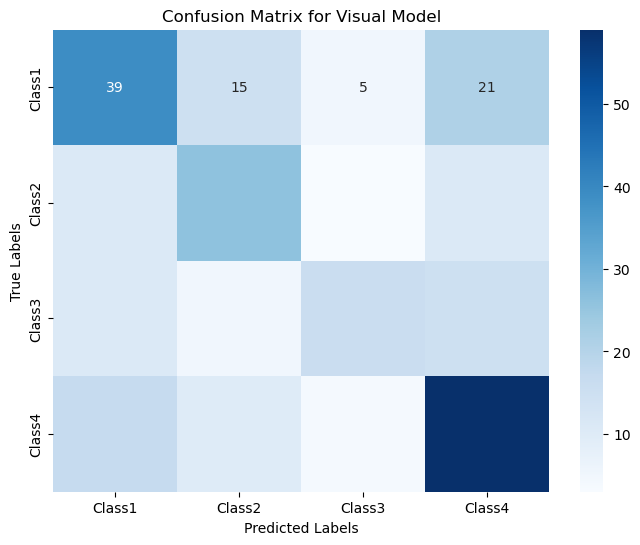

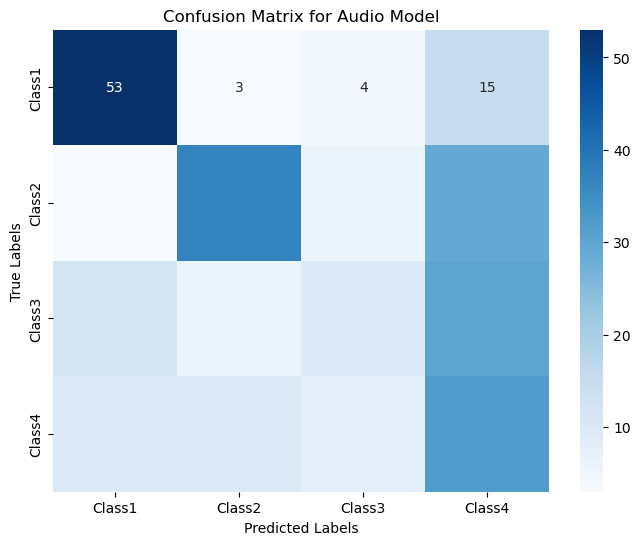

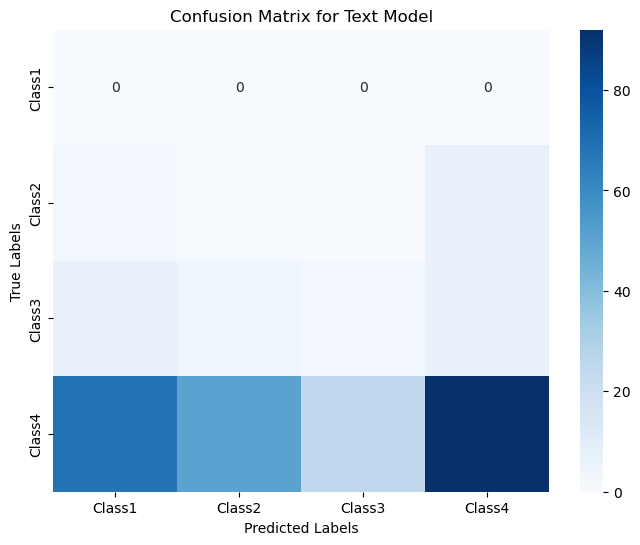

In [23]:
classes = ['Class1', 'Class2', 'Class3', 'Class4']

for feature_type, outputs in model_outputs.items():
    cm = confusion_matrix(outputs['val_preds'], outputs['val_labels'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    modality = feature_type.split('_')[1]  # Extract modality name from feature_type
    plt.title(f'Confusion Matrix for {modality.capitalize()} Model')
    plt.show()

In [18]:
best_params

{'learning_rate': 0.001,
 'optimizer': 'Adam',
 'criterion': 'CrossEntropyLoss',
 'epochs': 30,
 'batch_size': 16,
 'patience': 15,
 'weight_decay': 0,
 'validation_accuracy': 0.5634328358208955}